In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from data_generators.basic_generator import BasicDataGenerator
from data_generators.standard_generator import StandardDataGenerator
from environments.contextual_environment import ContextualEnvironment
from learners.pricing.contextual_learner import ContextualLearner
from learners.pricing.thompson_sampling import ThompsonSampling
from learners.pricing.ucb import UCB
from utils.context_generator import ContextGenerator 

In [2]:
src = 'src/basic005.json'

In [3]:
dg = StandardDataGenerator(filename=src)

In [4]:
selected_bid = 4
T = 365
n_experiments = 5
learners_to_test = [ThompsonSampling]
cg_start_from = 150
cg_confidence = 0.2
cg_frequency = 10

features = dg.get_features() 
fractions = dg.get_class_distributions(selected_bid)
bandit_args = {
            'arm_values': dg.get_margins()
}
env_args = {
    'bid_idx': selected_bid,
    'mode': 'all',
    'src': dg.get_source(),
    'generator': 'standard'
}

In [5]:
rewards_per_experiment = {}
context_split_per_experiment = {}
days_of_split = {}
for learner in learners_to_test:
    rewards_per_experiment[learner.LEARNER_NAME] = []
    context_split_per_experiment[learner.LEARNER_NAME] = []
    days_of_split[learner.LEARNER_NAME] = []

In [6]:
leaves_feature = {}
leaves_feature[True,True] = "C1"
leaves_feature[True,False] = "C3"
leaves_feature[False,True] = "C3"
leaves_feature[False,False] = "C2"
print(leaves_feature)



int_classes = {}
int_classes["C1"] = 0
int_classes["C2"] = 1
int_classes["C3"] = 2

int_to_feature_1 = {}
int_to_feature_1[0] = True
int_to_feature_1[1] = True
int_to_feature_1[2] = False
int_to_feature_1[3] = False

int_to_feature_2 = {}
int_to_feature_2[0] = True
int_to_feature_2[1] = False
int_to_feature_2[2] = True
int_to_feature_2[3] = False

splitted_rewards_per_experiment = {}
splitted_rewards_per_experiment[True,True] = []
splitted_rewards_per_experiment[True,False] = []
splitted_rewards_per_experiment[False,True] = []
splitted_rewards_per_experiment[False,False] = []

opt_per_experiment = {}
opt_per_experiment[True,True] = []
opt_per_experiment[True,False] = []
opt_per_experiment[False,True] = []
opt_per_experiment[False,False] = []

{(True, True): 'C1', (True, False): 'C3', (False, True): 'C3', (False, False): 'C2'}


In [7]:
margins = dg.get_margins()
classes = dg.get_classes()
conversion_rates = dg.get_conversion_rates(mode='all')
future_purchases = dg.get_future_purchases(mode='all')
selected_bid = 3
number_of_clicks = dg.get_daily_clicks(mode='all')
costs_per_click = dg.get_costs_per_click(mode='aggregate', bid=selected_bid)
fixed_cost = costs_per_click[selected_bid]
fixed_n_clicks = np.rint(dg.get_daily_clicks(mode='aggregate')[selected_bid]).astype(int)
fractions = dg.get_class_distributions(selected_bid)

temp = (margins * np.average(conversion_rates * (1 + future_purchases),
                             axis=0,
                             weights=fractions) - fixed_cost) * fixed_n_clicks
aggr_opt_arm = np.argmax(temp)
aggr_opt = np.max(temp)

disaggr_opt = 0
opt_arms = []
opt_values = []
for i, _ in enumerate(conversion_rates):
    t = (margins * conversion_rates[i] * (1 + future_purchases[i]) - fixed_cost) * \
                number_of_clicks[i, selected_bid]
    opt_arm = np.argmax(t)
    opt_value = np.max(t)
    opt_arms.append(opt_arm)
    opt_values.append(opt_value)
    disaggr_opt += opt_value

In [8]:
for e in range(n_experiments):
    # Initialization of the learners to test and their related environment:
    # the list is composed of tuples (Learner, Environment)
    print(f'\n\nrunning experiment {e + 1}/{n_experiments}...')
    test_instances = []
    
    for learner in learners_to_test:
        context_learner = ContextualLearner(features, learner, **bandit_args)
        test_instances.append(
            (context_learner,
             ContextualEnvironment(**env_args),
             ContextGenerator(features=features,
                              contextual_learner=context_learner,
                              update_frequency=cg_frequency,
                              start_from=cg_start_from,
                              confidence=cg_confidence,
                              verbose=0))
        )
    for t in range(T):
        for context_learner, env, context_generator in test_instances:
            #print(f'##### DAY {t} ######')
            context_learner.next_day()
            past_arms = env.get_selected_arms_at_day(t - 30, keep=False, filter_purchases=True)
            past_features = env.get_collected_user_features_at_day(t - 30, keep=False, filter_purchases=True)
            month_purchases = env.get_next_purchases_at_day(t, keep=True, filter_purchases=True)
            if month_purchases is not None:
                context_learner.update_next_purchases(past_arms, month_purchases, past_features)

            pulled_arms = context_learner.pull_arms()
            daily_rewards = env.day_round(pulled_arms)
            daily_users_features = env.get_collected_user_features_at_day(t)
            daily_pulled_arms = env.get_selected_arms_at_day(t)
            
            context_learner.update(daily_rewards, daily_pulled_arms, daily_users_features)
            context_generator.collect_daily_data(daily_pulled_arms, 
                                                 daily_rewards, 
                                                 daily_users_features,
                                                 next_purchases=month_purchases, 
                                                 past_pulled_arms=past_arms,
                                                 past_features=past_features)
    for learner, _, _ in test_instances:
        learner.next_day()
        rewards_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_daily_rewards())
        context_split_per_experiment[learner.base_learner_class.LEARNER_NAME].append(learner.get_splits_count())
        days_of_split[learner.base_learner_class.LEARNER_NAME].append(context_generator.metadata['SPLIT_DAYS'])
    # end -> save rhe results.
        if learner.base_learner_class.LEARNER_NAME == 'TS-Pricing':
        #split_day=learner.context_tree.collected_splits[0]+16#should be a list, returns only one value??
            if len(learner.context_tree.get_leaves()) == 4:
                for leaf in learner.context_tree.get_leaves():
                    print(f"feature subspace: {leaf.feature_subspace}")
                    feature_2=leaf.feature_subspace['feature-2']
                    feature_1=leaf.feature_subspace['feature-1']
                    leaf_class=leaves_feature[feature_1,feature_2]
                    leaf_values=leaf.get_daily_rewards()

                    print(f"leaf class: {leaf_class} ")
                    print(f"leaf values: {leaf_values}")
                    print(len(leaf_values))
                    split_day=T-len(leaf_values)
                    print(split_day)
                    splitted_rewards_per_experiment[feature_1,feature_2].append(leaf_values) #save rewards for specific leaf
                    opt_single = opt_values[int_classes[leaf_class]] #calculate opt for specific leaf 
                    opt=[]
                    for relative_day,val in enumerate(leaf_values): #
                        curr_day=split_day+relative_day
                        custom_clicks=env.collected_users_categories[curr_day,leaf_class] #call function on the env that returns n of clicks for current day
                        optimal_value= opt_single #* custom_clicks
                        opt.append(optimal_value)
                    opt_per_experiment[feature_1,feature_2].append(opt) #save list of optimal values for the current leaf specified by her features





running experiment 1/5...


running experiment 2/5...
feature subspace: {'feature-2': False, 'feature-1': False}
leaf class: C2 
leaf values: [ 55.6493617   39.40050633  83.60303797  39.40050633  18.45050279
  47.29793103 106.47034483  34.79492063  -2.90349206  27.2552381
  51.41925926  34.57811847  27.2552381   19.71555556  34.04405797
  33.62268657  18.4562963   50.54746439  58.57025641  83.55612188
 107.03866109  47.69138075   2.58307692  -4.23748954  40.96544747
  18.64372093 -18.73416058  73.80989059  -3.62350515  48.69608247
  33.27392405  33.27392405  24.73142857  25.33299578  25.12730245
  40.71441478  62.18919708   2.93751756  25.11890411  32.80476386
  25.49333333  -4.25059603 153.00393064 -22.14828516 -22.14828516
  17.86786517  -4.0026506   32.88340426 111.92632302  16.86646766
  40.5679602   32.66746269   1.15674267  48.6095114   96.06228013
  24.60736842  17.2477193  -25.84        24.44813559  64.86788253
  45.96263158  71.7966322   40.26930576  16.50442836  47.99502171



running experiment 5/5...


In [9]:

env.collected_users_categories

len(learner.context_tree.get_leaves())

len(opt_per_experiment[False,False])



2

In [10]:
for e in range(len(opt_per_experiment[False,False])):
    for i in range(4):
        feature_1=int_to_feature_1[i]
        feature_2=int_to_feature_2[i]
        for j in range(365-len(splitted_rewards_per_experiment[feature_1,feature_2][e])):
            splitted_rewards_per_experiment[feature_1,feature_2][e]=np.insert(splitted_rewards_per_experiment[feature_1,feature_2][e],0,0,axis=0)
            opt_per_experiment[feature_1,feature_2][e]=np.insert(opt_per_experiment[feature_1,feature_2][e],0,0,axis=0)
          
                   

[array([  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
         0.      ,   0.      ,   0.      ,   0.      ,   0.  

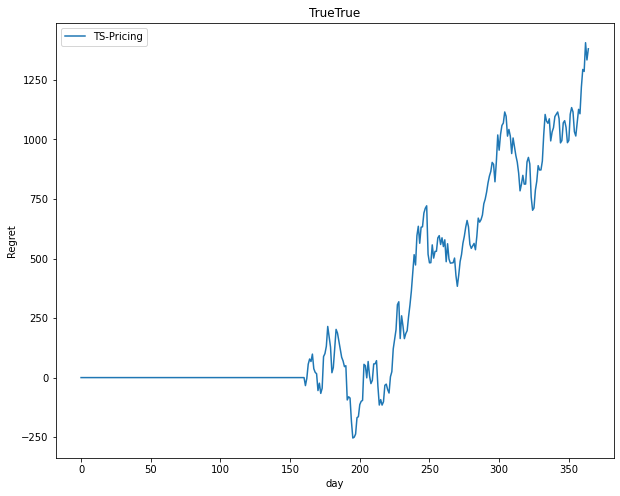

[array([  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.

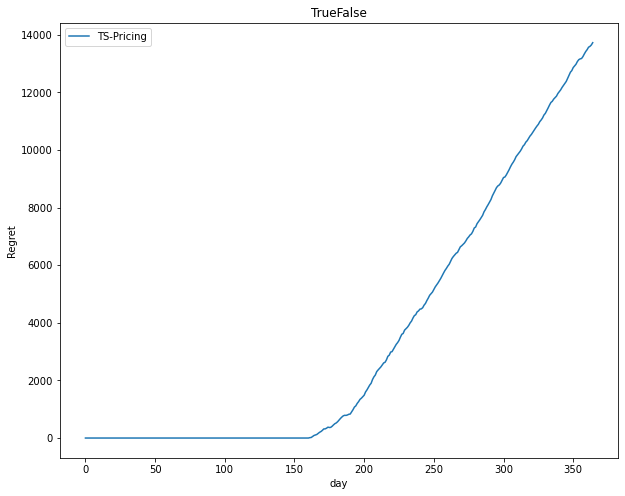

[array([  0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ,   0.    ,   0.

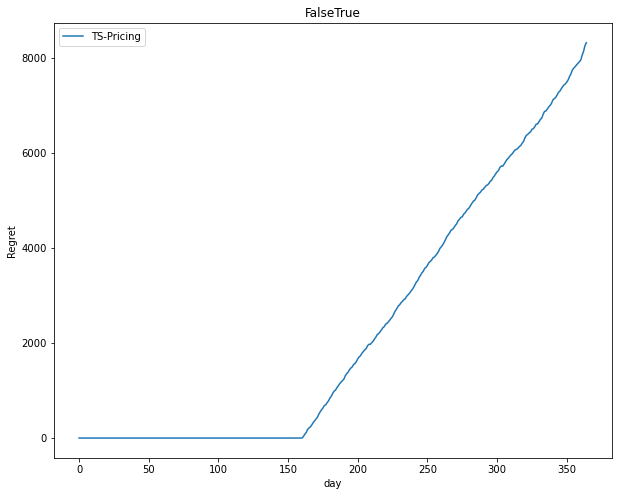

[array([ 0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0.     ,
        0.     ,  0.     ,  0.     ,  0.     ,  0.     ,  0. 

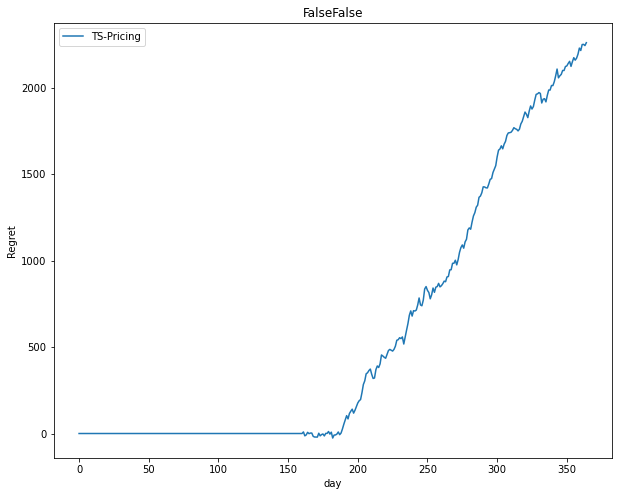

In [11]:


for i in range(4):
    feature_1 = int_to_feature_1[i]
    feature_2 = int_to_feature_2[i]
    val = splitted_rewards_per_experiment[feature_1,feature_2]
    opt = opt_per_experiment[feature_1,feature_2]
    print(opt)
    print(val)
    plt.figure(figsize=(10,8))
    plt.ylabel("Regret")
    plt.xlabel("day")
    plt.title(f"{feature_1}{feature_2}")
    plt.plot(np.cumsum(np.mean(np.array(opt) - np.array(val), axis=0)))

    plt.legend(rewards_per_experiment.keys())
    plt.show()

In [12]:
opt_values


[927.1033140000002, 48.80595999999999, 145.7828]

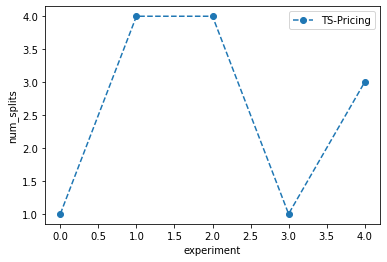

In [13]:
plt.figure()
plt.ylabel("num_splits")
plt.xlabel("experiment")
for val in context_split_per_experiment.values():
    plt.plot(val, '--o')
plt.legend(context_split_per_experiment.keys())
plt.show()

In [14]:
for key in context_split_per_experiment:
    print(f'{key}: avg splits -> {np.mean(context_split_per_experiment[key])}')

TS-Pricing: avg splits -> 2.6


In [15]:
val = days_of_split[ThompsonSampling.LEARNER_NAME]
avg_days = np.mean(val, axis=0)
val, avg_days

C:\Users\filip\anaconda3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


TypeError: unsupported operand type(s) for /: 'list' and 'int'

In [ ]:
# Plotting the results
plt.figure(figsize=(10,8))
plt.ylabel("Regret")
plt.xlabel("day")
for val in rewards_per_experiment.values():
    plt.plot(np.cumsum(np.mean(disaggr_opt - val, axis=0)))

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
for val in days_of_split.values():
    avg_days = np.mean(val, axis=0)
    for day in avg_days:
        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(rewards_per_experiment.keys())
plt.show()

In [ ]:
plt.figure(figsize=(10,8))
plt.xlabel("day")
plt.ylabel("daily reward")
plt.plot([disaggr_opt]*T, '--g', label='clairwoyant')
plt.plot([aggr_opt]*T, '--c', label='aggr_clairwoyant')
for key in rewards_per_experiment:
    plt.plot(np.mean(rewards_per_experiment[key], axis=0), label=key)

#plt.axvline(x=cg_start_from, color='r', linestyle='--')
for val in days_of_split.values():
    avg_days = np.mean(val, axis=0)
    for day in avg_days:
        plt.axvline(x=day, color='m', linestyle='--')

plt.legend(loc='best')
plt.show()